# Module 15 and 16 Data Set: Predicting New Customers

The following data set originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). It includes data related to direct marketing campaigns of Portuguese banking institutions.


The data dictionary and original data can be found [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

Using classification methods discussed so far, predict whether a client will subscribe to a term deposit.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter
from numpy import where

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score, roc_curve, auc, roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OrdinalEncoder

In [2]:
DATAFILE = 'bank-full.csv'

# Help Functions

In [131]:
def read_data(data_file):
    return pd.read_csv(data_file, sep=';')
    
def bank_data_x_y():
    df = read_data(DATAFILE)
    X = df.drop('y', axis=1)
    y = df['y']
    return X,y

def bank_pp_data_x_y():
    df = bank_pp
    X = df.drop('has_client_subsc', axis=1)
    y = df['has_client_subsc']
    return X,y

def predict_data(data_x_y, classification_model):
    X, y = data_x_y()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classification_model.fit(X_train, y_train)
    return classification_model.predict(X_test)

def decision_tree_model():
    return tree.DecisionTreeClassifier()

def logistic_regression_binary_clf():
    return LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

def balanced_random_forest_clf():
    return BalancedRandomForestClassifier(n_estimators=100, random_state=0)

def linear_svc_clf():
    return LinearSVC(C=1.0, max_iter=1000, tol=1e-3)

def knn_clf():
    return KNeighborsClassifier(n_neighbors = 5)

def model_metrics(data_actual, data_pred):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 6))
    fig.subplots_adjust(wspace=1)
    df_clf_report = pd.DataFrame(classification_report(data_actual, data_pred, output_dict=True)).T
    print(df_clf_report)
    c_m = confusion_matrix(data_actual, data_pred)
    ax1.set(title = "Confisuon Matrix", ylabel = "Actual Data", xlabel = "Predicted Data")
    sns.heatmap(c_m, annot=True, fmt=".0f", ax=ax1, square=True, cbar_kws={'orientation': 'horizontal'}) #, vmin=0, vmax=max(map(lambda x: x[2], c_m))
    sns.heatmap(df_clf_report.iloc[: , :-1], annot=True, ax=ax2, square=True, cbar_kws={'orientation': 'horizontal'}) # , vmin=0, vmax=1
    plt.yticks(rotation=0)
    
def plot_roc(data1, data2, model):
    plt.figure(figsize=(6,6))
    plt.xlabel('FPR', fontsize = 20)
    plt.ylabel('TPR', fontsize = 20)
    plt.title('ROC Curve')
    plt.plot([0,1],[0,1], 'r--', label='Random Guess')
    y_pred_proba = model.predict_proba(data1)[:,1]  
    fpr, tpr, _ = roc_curve(data2,  y_pred_proba)
    auc = roc_auc_score(data2, y_pred_proba)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    
#plot_roc2 has been taken from Rob´s Office Hour Week16
def plot_roc2(data1, data2, model):
    fpr, tpr, _ = roc_curve(data2, model.predict_proba(data1)[:,1])
    model_auc = auc(fpr,tpr)

    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1])
    plt.xlabel('FPR', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.ylabel('TPR', fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('ROC Curve\nAUC : ' + str(model_auc.round(3)), fontsize = 18)
    plt.plot(fpr, tpr)
 
    
def classification_app(data_x_y, classification_model, is_roc_plot_needed=True):
    X, y = data_x_y()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    model = classification_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    
    #BK: There is some difficulties to draw ROC. Thisis temporarly solution. TODO: find alternative ways!
    if(is_roc_plot_needed is True):
        plot_roc(X_test, y_test, model)

    
def classification_app_inbld(data_x_y, classification_model, imblearn_method, is_test_oversampled, is_roc_plot_needed=True):
    
    X, y = data_x_y()
    
    if is_test_oversampled == False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, y_train = imblearn_method().fit_sample(X_train, y_train)
    else:
        X_imb, y_imb = imblearn_method().fit_sample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)
 
    model = classification_model()
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test)
    
    model_metrics(y_test, y_pred)
    
    #BK: There is some difficulties to draw ROC. Thisis temporarly solution. TODO: find alternative ways!
    if(is_roc_plot_needed is True):
        plot_roc(X_test, y_test, model)

# Data Set Overview

 https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
 default: has credit in default?
 
 housing: has housing loan?
 
 loan: has personal loan?
 
 contact: contact communication type
 
 month: last contact month of year
 
 pdays: number of days that passed by after the client was last contacted from a previous campaign
 
 previous: number of contacts performed before this campaign and for this client 
 
 poutcome: outcome of the previous marketing campaign 
 
 default: has credit in default? (categorical: 'no','yes','unknown')
 
 y: has the client subscribed a term deposit?

In [4]:
bank = read_data(DATAFILE)
print(bank.shape)
bank.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


no     39922
yes     5289
Name: y, dtype: int64


<AxesSubplot:>

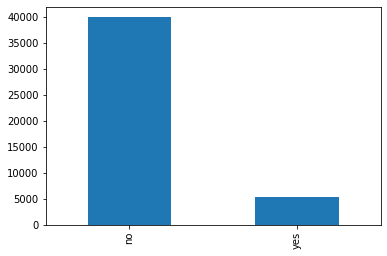

In [5]:
y_class = bank["y"].value_counts()
print(y_class)
y_class.plot(kind="bar")

In [6]:
yes = np.round(bank['y'].value_counts(normalize=True)[0]*100,4)
no = np.round(bank['y'].value_counts(normalize=True)[1]*100,5)
print("% of yes:\t", yes)
print("% of no:\t", no)

% of yes:	 88.3015
% of no:	 11.69848


# Data preprocess

Categorial features encoding

In [7]:
missing_values = ["unknown"]
bank_pp = pd.read_csv('bank-full.csv', sep=';', na_values = missing_values)
print(bank_pp.shape)
bank_pp.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [8]:
bank_pp = bank_pp.dropna()
print(bank_pp.shape)
bank_pp.head()

(7842, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
24062,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,yes
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
24072,36,management,married,tertiary,no,2415,yes,no,telephone,22,oct,73,1,86,4,other,no
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes


In [9]:
cat_features=[i for i in bank.columns if bank.dtypes[i]=='object']

In [10]:
print(cat_features)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [11]:
ordinal_cat_features = ['education']
nominal_cat_features = ['job', 'marital', 'contact', 'month', 'poutcome'] # + ['default', 'housing', 'loan', 'y']
binary_coding_feature = ['default', 'housing', 'loan', 'y']

In [12]:
#print(([bank[column].value_counts() for column in cat_features]))
'''for column in cat_features:
    print(pd.crosstab(bank_pp[column], bank_pp['y']))
    print('\n')'''

"for column in cat_features:\n    print(pd.crosstab(bank_pp[column], bank_pp['y']))\n    print('\n')"

In [13]:
bank_pp['has_client_subsc'] = bank_pp['y'].map(lambda x : 1 if x == 'yes' else 0)

bank_pp['has_personal_loan'] = bank_pp['loan'].map(lambda x : 1 if x == 'yes' else 0)

bank_pp['has_housing_loan'] = bank_pp['housing'].map(lambda x : 1 if x == 'yes' else 0)

bank_pp['has_credit_default'] = bank_pp['default'].map(lambda x : 1 if x == 'yes' else 0)

bank_pp.drop(binary_coding_feature, axis=1, inplace=True)
#bank_pp.head()


In [14]:
categories=['primary', 'secondary', 'tertiary']
encoder = OrdinalEncoder()
bank_pp['education_l'] = encoder.fit_transform(bank_pp['education'].values.reshape(-1, 1))
#print(bank_pp[["education", "education_l"]].head(50))
bank_pp.drop('education', axis=1, inplace=True)

In [15]:
bank_pp=pd.get_dummies(bank_pp)

bank_pp.head()

,age,balance,day,duration,campaign,pdays,previous,has_client_subsc,has_personal_loan,has_housing_loan,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
24060,33,882,21,39,1,151,3,0,0,0,...,0,0,0,0,0,1,0,1,0,0
24062,42,-247,21,519,1,166,1,1,1,1,...,0,0,0,0,0,1,0,0,1,0
24064,33,3444,21,144,1,91,4,1,0,1,...,0,0,0,0,0,1,0,1,0,0
24072,36,2415,22,73,1,86,4,0,0,1,...,0,0,0,0,0,1,0,0,1,0
24077,36,0,23,140,1,143,3,1,0,1,...,0,0,0,0,0,1,0,1,0,0


In [16]:
print([i for i in bank_pp.columns if bank_pp.dtypes[i]=='object'])

[]


# I. Classifier Models without Imbalanced Learn Methods

# Decision Tree Classifier

              precision    recall  f1-score      support
0              0.875314  0.871667  0.873486  1200.000000
1              0.588235  0.596206  0.592194   369.000000
accuracy       0.806883  0.806883  0.806883     0.806883
macro avg      0.731775  0.733936  0.732840  1569.000000
weighted avg   0.807798  0.806883  0.807332  1569.000000


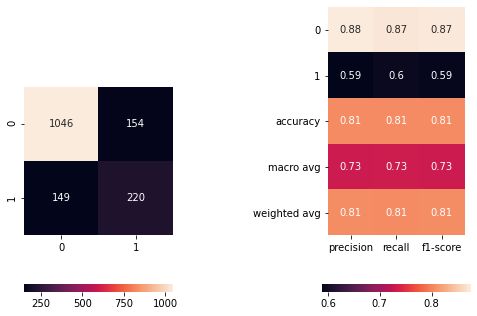

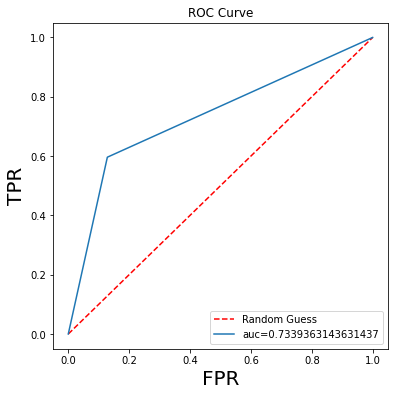

In [112]:
classification_app(bank_pp_data_x_y, decision_tree_model)

# Logistic Regression Binary Classifier

              precision    recall  f1-score      support
0              0.872642  0.925000  0.898058  1200.000000
1              0.696970  0.560976  0.621622   369.000000
accuracy       0.839388  0.839388  0.839388     0.839388
macro avg      0.784806  0.742988  0.759840  1569.000000
weighted avg   0.831327  0.839388  0.833045  1569.000000


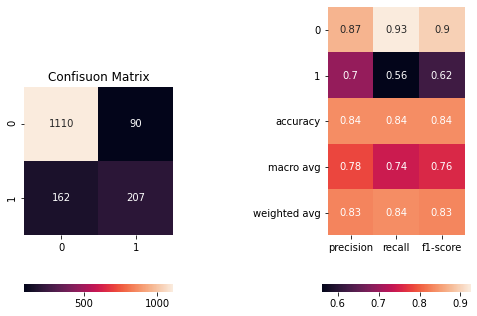

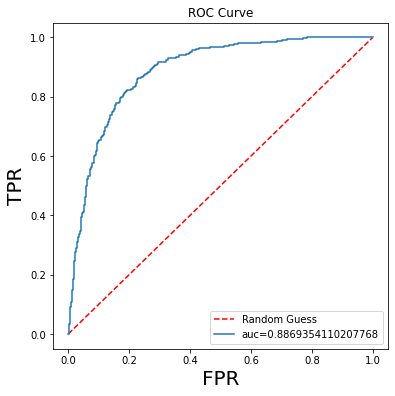

In [126]:
classification_app(bank_pp_data_x_y, logistic_regression_binary_clf)

# Linear SVC Classifier

c:\users\bilgen\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score      support
0              0.847647  0.945833  0.894053  1200.000000
1              0.717391  0.447154  0.550918   369.000000
accuracy       0.828553  0.828553  0.828553     0.828553
macro avg      0.782519  0.696494  0.722485  1569.000000
weighted avg   0.817014  0.828553  0.813354  1569.000000


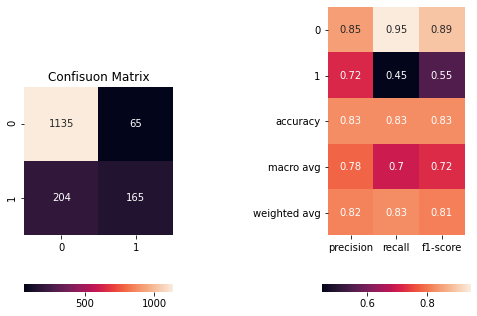

In [127]:
classification_app(bank_pp_data_x_y, linear_svc_clf, False)

# K-Nearest-Neighbor Classifier

              precision    recall  f1-score      support
0              0.817418  0.891667  0.852929  1200.000000
1              0.500000  0.352304  0.413355   369.000000
accuracy       0.764818  0.764818  0.764818     0.764818
macro avg      0.658709  0.621985  0.633142  1569.000000
weighted avg   0.742767  0.764818  0.749550  1569.000000


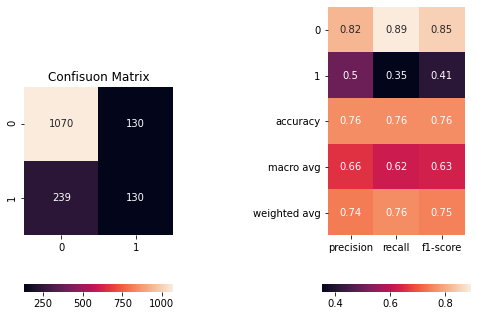

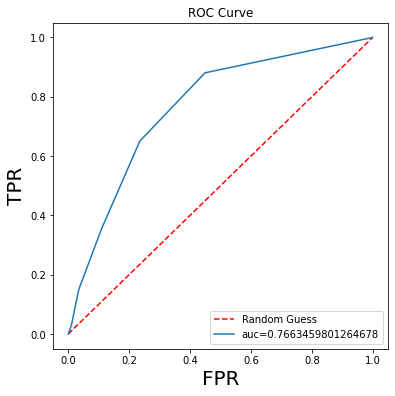

In [128]:
classification_app(bank_pp_data_x_y, knn_clf)

# II. Classifier Models with Imbalanced Learn Methods

# Balanced Random Forest Classifier

              precision    recall  f1-score      support
0              0.951172  0.811667  0.875899  1200.000000
1              0.585321  0.864499  0.698031   369.000000
accuracy       0.824092  0.824092  0.824092     0.824092
macro avg      0.768246  0.838083  0.786965  1569.000000
weighted avg   0.865130  0.824092  0.834068  1569.000000


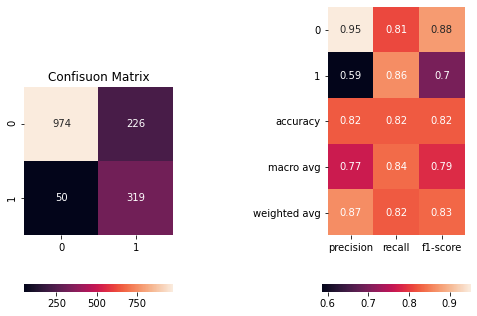

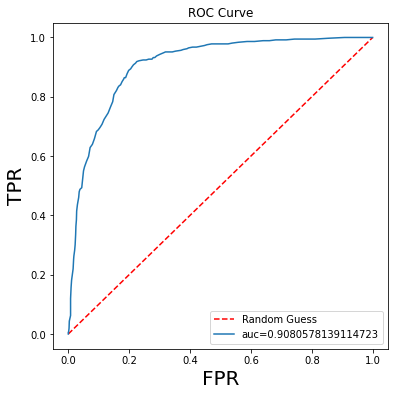

In [129]:
classification_app(bank_pp_data_x_y, balanced_random_forest_clf)

# Decision Tree Classification + ADASYN + Test data not oversampled

              precision    recall  f1-score      support
0              0.884220  0.859167  0.871513  1200.000000
1              0.580645  0.634146  0.606218   369.000000
accuracy       0.806246  0.806246  0.806246     0.806246
macro avg      0.732432  0.746657  0.738865  1569.000000
weighted avg   0.812824  0.806246  0.809120  1569.000000


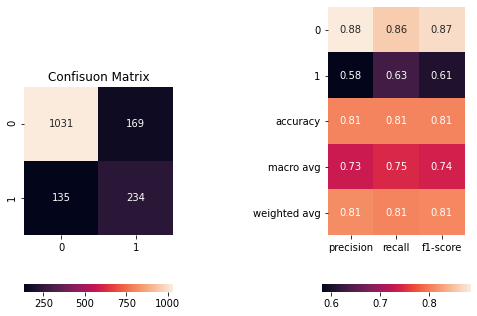

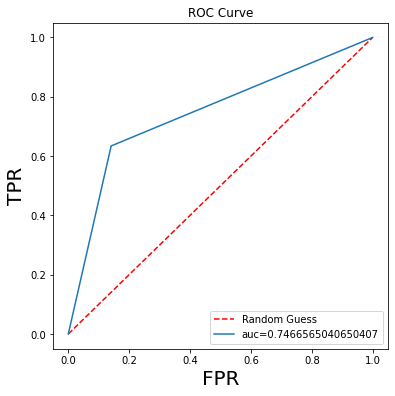

In [132]:
classification_app_inbld(bank_pp_data_x_y, decision_tree_model, ADASYN, False)

# Decision Tree Classification + ADASYN + Test data oversampled

              precision    recall  f1-score      support
0              0.855132  0.857261  0.856196  1205.000000
1              0.853866  0.851695  0.852779  1180.000000
accuracy       0.854507  0.854507  0.854507     0.854507
macro avg      0.854499  0.854478  0.854487  2385.000000
weighted avg   0.854506  0.854507  0.854505  2385.000000


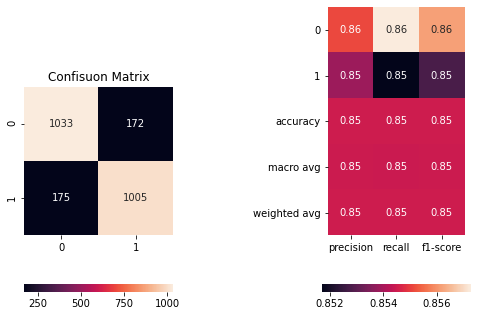

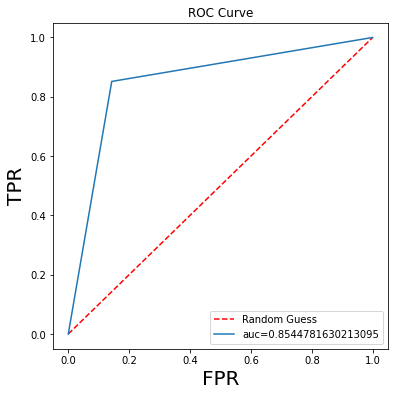

In [133]:
classification_app_inbld(bank_pp_data_x_y, decision_tree_model, ADASYN, True)

# Decision Tree Classification + SMOTE + Test data not oversampled

              precision    recall  f1-score      support
0              0.870196  0.849167  0.859553  1200.000000
1              0.545226  0.588076  0.565841   369.000000
accuracy       0.787763  0.787763  0.787763     0.787763
macro avg      0.707711  0.718621  0.712697  1569.000000
weighted avg   0.793769  0.787763  0.790477  1569.000000


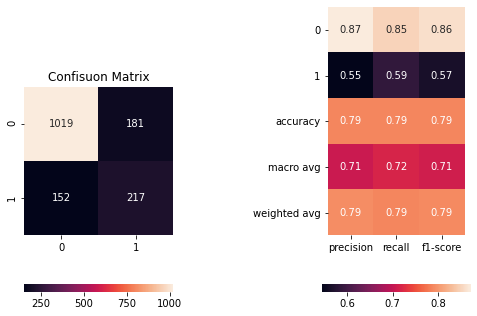

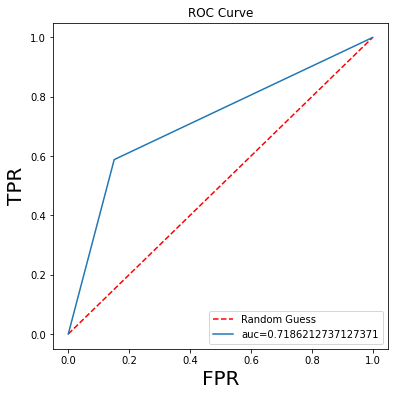

In [134]:
classification_app_inbld(bank_pp_data_x_y, decision_tree_model, SMOTE, False)

# Decision Tree Classification + SMOTE + Test data oversampled

              precision    recall  f1-score      support
0              0.874680  0.860017  0.867287  1193.000000
1              0.866400  0.880488  0.873387  1230.000000
accuracy       0.870409  0.870409  0.870409     0.870409
macro avg      0.870540  0.870252  0.870337  2423.000000
weighted avg   0.870477  0.870409  0.870383  2423.000000


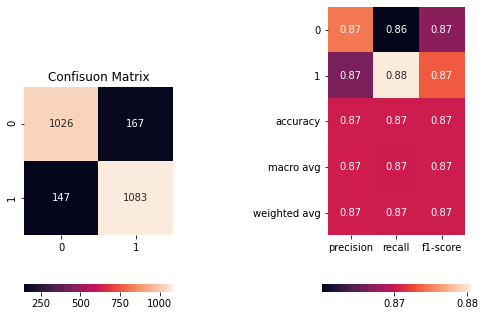

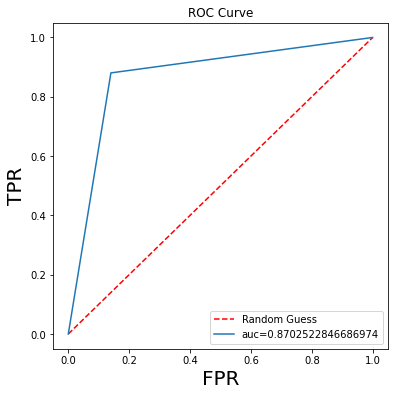

In [135]:
classification_app_inbld(bank_pp_data_x_y, decision_tree_model, SMOTE, True)

# Logistic Regression Binary Classifier + ADASYN + Test data not oversampled

              precision    recall  f1-score      support
0              0.877486  0.919167  0.897843  1200.000000
1              0.689103  0.582656  0.631424   369.000000
accuracy       0.840025  0.840025  0.840025     0.840025
macro avg      0.783294  0.750911  0.764634  1569.000000
weighted avg   0.833182  0.840025  0.835186  1569.000000


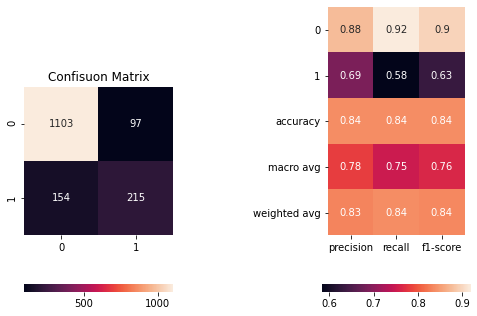

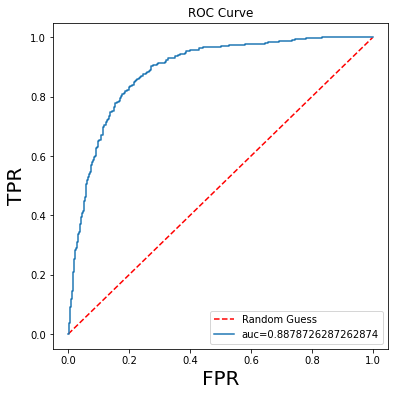

In [136]:
classification_app_inbld(bank_pp_data_x_y, logistic_regression_binary_clf, ADASYN, False)

# Logistic Regression Binary Classifier + SMOTE + Test data not oversampled

              precision    recall  f1-score      support
0              0.879297  0.916667  0.897593  1200.000000
1              0.685535  0.590786  0.634643   369.000000
accuracy       0.840025  0.840025  0.840025     0.840025
macro avg      0.782416  0.753726  0.766118  1569.000000
weighted avg   0.833727  0.840025  0.835752  1569.000000


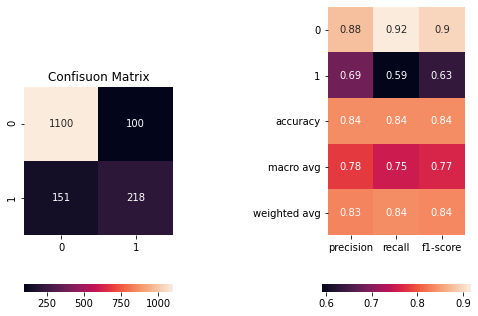

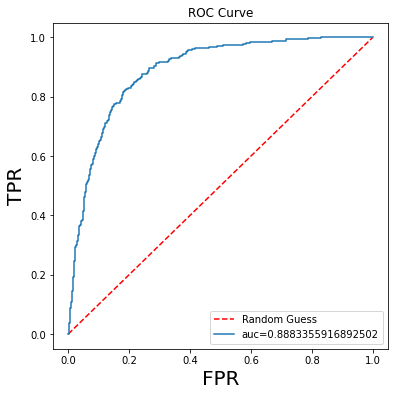

In [137]:
classification_app_inbld(bank_pp_data_x_y, logistic_regression_binary_clf, SMOTE, False)